# Lesson 3 Module 4: Confidence Intervals

This notebook demonstrates confidence interval construction and comparison using practical examples.
It applies Lesson 1 (CLT) and Lesson 2 (delta method) to quantify uncertainty.

## Learning Objectives
- Define (1−α) confidence intervals and interpret correctly
- Derive classical CIs: Normal mean, t-intervals, variance, proportions
- Compare proportion CI methods using A/B testing data
- Understand pivots and asymptotic CIs (delta method)

## Repository Context
- Uses `ci_prop_*` functions from the appendix
- Uses `shared/data/ab_test_clicks.csv` for A/B testing examples
- Applies Lesson 1 (CLT) and Lesson 2 (delta method) concepts

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style and random seed
sns.set_theme(context="talk", style="whitegrid")
sns.set_palette(["#000000", "#E69F00", "#56B4E9", "#009E73",
                 "#F0E442", "#0072B2", "#D55E00", "#CC79A7"])
rng = np.random.default_rng(2025)

print("Environment setup complete. Random seed: 2025")

Environment setup complete. Random seed: 2025


## 1. Confidence Interval Functions

Using the functions from the appendix to compute various confidence intervals.

In [5]:
# CI functions (from appendix)
def ci_prop_wald(k, n, alpha=0.05):
    p = k/n
    z = stats.norm.ppf(1 - alpha/2)
    hw = z*np.sqrt(max(p*(1-p)/n, 0.0))
    return max(0.0, p-hw), min(1.0, p+hw)

def ci_prop_wilson(k, n, alpha=0.05):
    if n==0: return (np.nan, np.nan)
    z = stats.norm.ppf(1 - alpha/2)
    p = k/n
    denom = 1 + z**2/n
    center = (p + z**2/(2*n)) / denom
    adj = p*(1-p)/n + z**2/(4*n**2)
    hw = z/denom * np.sqrt(adj)
    return max(0.0, center - hw), min(1.0, center + hw)

def ci_prop_agresti_coull(k, n, alpha=0.05):
    z = stats.norm.ppf(1 - alpha/2)
    ntilde = n + z**2
    ptilde = (k + z**2/2) / ntilde
    hw = z*np.sqrt(ptilde*(1-ptilde)/ntilde)
    return max(0.0, ptilde-hw), min(1.0, ptilde+hw)

def ci_prop_clopper_pearson(k, n, alpha=0.05):
    a = alpha/2
    if k==0:
        lo = 0.0
    else:
        lo = stats.beta.ppf(a, k, n-k+1)
    if k==n:
        hi = 1.0
    else:
        hi = stats.beta.ppf(1-a, k+1, n-k)
    return lo, hi

print("CI functions defined")

CI functions defined


In [6]:
# Test CI functions
k, n = 15, 50  # 15 successes out of 50 trials
alpha = 0.05

wald_lo, wald_hi = ci_prop_wald(k, n, alpha)
wilson_lo, wilson_hi = ci_prop_wilson(k, n, alpha)
ac_lo, ac_hi = ci_prop_agresti_coull(k, n, alpha)
cp_lo, cp_hi = ci_prop_clopper_pearson(k, n, alpha)

print(f"Wald: [{wald_lo:.4f}, {wald_hi:.4f}] (length: {wald_hi-wald_lo:.4f})")
print(f"Wilson: [{wilson_lo:.4f}, {wilson_hi:.4f}] (length: {wilson_hi-wilson_lo:.4f})")
print(f"Agresti-Coull: [{ac_lo:.4f}, {ac_hi:.4f}] (length: {ac_hi-ac_lo:.4f})")
print(f"Clopper-Pearson: [{cp_lo:.4f}, {cp_hi:.4f}] (length: {cp_hi-cp_lo:.4f})")

Wald: [0.1730, 0.4270] (length: 0.2540)
Wilson: [0.1910, 0.4375] (length: 0.2465)
Agresti-Coull: [0.1903, 0.4383] (length: 0.2480)
Clopper-Pearson: [0.1786, 0.4461] (length: 0.2675)


## 2. Normal Mean Confidence Intervals

Compare Z-intervals and t-intervals for Normal data.

In [7]:
def ci_mean_known_sigma(xbar, sigma, n, alpha=0.05):
    """Z-interval for mean with known sigma"""
    z = stats.norm.ppf(1 - alpha/2)
    se = sigma / np.sqrt(n)
    return xbar - z*se, xbar + z*se

def ci_mean_t(x, alpha=0.05):
    """t-interval for mean with unknown sigma"""
    n = len(x)
    xbar = np.mean(x)
    s = np.std(x, ddof=1)
    t_crit = stats.t.ppf(1 - alpha/2, n-1)
    se = s / np.sqrt(n)
    return xbar - t_crit*se, xbar + t_crit*se

print("CI functions for means defined")

CI functions for means defined


In [5]:
# Demonstrate mean CIs
true_mu = 170.0
true_sigma = 15.0
n = 25

# Generate sample
sample = rng.normal(true_mu, true_sigma, n)
xbar = np.mean(sample)

# Compute intervals
z_lo, z_hi = ci_mean_known_sigma(xbar, true_sigma, n)
t_lo, t_hi = ci_mean_t(sample)

print(f"Sample mean: {xbar:.3f}")
print(f"Z-interval (σ known): [{z_lo:.3f}, {z_hi:.3f}] (length: {z_hi-z_lo:.3f})")
print(f"t-interval (σ unknown): [{t_lo:.3f}, {t_hi:.3f}] (length: {t_hi-t_lo:.3f})")
print(f"True μ = {true_mu} contained in Z-interval: {z_lo <= true_mu <= z_hi}")
print(f"True μ = {true_mu} contained in t-interval: {t_lo <= true_mu <= t_hi}")

Sample mean: 167.505
Z-interval (σ known): [161.625, 173.385] (length: 11.760)
t-interval (σ unknown): [159.814, 175.196] (length: 15.383)
True μ = 170.0 contained in Z-interval: True
True μ = 170.0 contained in t-interval: True


## 3. Proportion CI Comparison with A/B Testing Data

Using the A/B testing dataset to compare proportion confidence intervals.

In [4]:
# Load A/B testing data
ab_data = pd.read_csv("../../../shared/data/ab_test_clicks.csv")
print("A/B testing data shape:", ab_data.shape)
print("Columns:", ab_data.columns.tolist())
print("\nFirst few rows:")
print(ab_data.head())

# Compute click-through rates by variant
ctr_by_variant = ab_data.groupby('variant')['clicks'].agg(['count', 'sum', 'mean'])
ctr_by_variant.columns = ['n', 'clicks', 'ctr']
print("\nClick-through rates by variant:")
print(ctr_by_variant)

A/B testing data shape: (10, 4)
Columns: ['user_id', 'variant', 'impressions', 'clicks']

First few rows:
  user_id variant  impressions  clicks
0    u001       A            5       0
1    u002       B            7       2
2    u003       A            3       1
3    u004       B            2       0
4    u005       A            4       1

Click-through rates by variant:
         n  clicks  ctr
variant                
A        5       5  1.0
B        5       6  1.2


In [ ]:
# Compute CIs for each variant
alpha = 0.05
variants = ctr_by_variant.index

for variant in variants:
    n = ctr_by_variant.loc[variant, 'n']
    clicks = ctr_by_variant.loc[variant, 'clicks']
    ctr = ctr_by_variant.loc[variant, 'ctr']

    wald_lo, wald_hi = ci_prop_wald(clicks, n, alpha)
    wilson_lo, wilson_hi = ci_prop_wilson(clicks, n, alpha)
    ac_lo, ac_hi = ci_prop_agresti_coull(clicks, n, alpha)
    cp_lo, cp_hi = ci_prop_clopper_pearson(clicks, n, alpha)

    print(f"\n{variant} (CTR = {ctr:.4f}):")
    print(f"  Wald: [{wald_lo:.4f}, {wald_hi:.4f}] (length: {wald_hi-wald_lo:.4f})")
    print(f"  Wilson: [{wilson_lo:.4f}, {wilson_hi:.4f}] (length: {wilson_hi-wilson_lo:.4f})")
    print(f"  Agresti-Coull: [{ac_lo:.4f}, {ac_hi:.4f}] (length: {ac_hi-ac_lo:.4f})")
    print(f"  Clopper-Pearson: [{cp_lo:.4f}, {cp_hi:.4f}] (length: {cp_hi-cp_lo:.4f})")

## 4. Coverage Simulation for Proportion CIs

Simulate empirical coverage rates for different CI methods.

In [8]:
def coverage_curve(n=20, R=10000, alpha=0.05, rng=None):
    """Empirical coverage for multiple CI methods across a grid of p values."""
    rng = np.random.default_rng() if rng is None else rng
    ps = np.linspace(0.02, 0.98, 25)
    methods = {
        "Wald": ci_prop_wald,
        "Wilson": ci_prop_wilson,
        "Agresti–Coull": ci_prop_agresti_coull,
        "Clopper–Pearson": ci_prop_clopper_pearson
    }
    rows=[]
    for p in ps:
        for name, fn in methods.items():
            cover=0
            for r in range(R):
                k = rng.binomial(n, p)
                lo, hi = fn(k, n, alpha)
                cover += (lo <= p) and (p <= hi)
            rows.append((p, name, cover/R))
    return pd.DataFrame(rows, columns=["p","method","coverage"])

print("Function defined: coverage_curve")

Function defined: coverage_curve


In [9]:
# Compute coverage curves
coverage_results = coverage_curve(n=20, R=5000, rng=rng)
print("Coverage simulation complete")
print("Summary by method:")
print(coverage_results.groupby('method')['coverage'].describe().round(4))

Coverage simulation complete
Summary by method:
                 count    mean     std     min     25%     50%     75%     max
method                                                                        
Agresti–Coull     25.0  0.9631  0.0154  0.9318  0.9570  0.9608  0.9728  0.9950
Clopper–Pearson   25.0  0.9762  0.0117  0.9570  0.9664  0.9772  0.9864  0.9944
Wald              25.0  0.8524  0.1687  0.3318  0.8736  0.9264  0.9306  0.9542
Wilson            25.0  0.9525  0.0162  0.9290  0.9384  0.9534  0.9650  0.9792


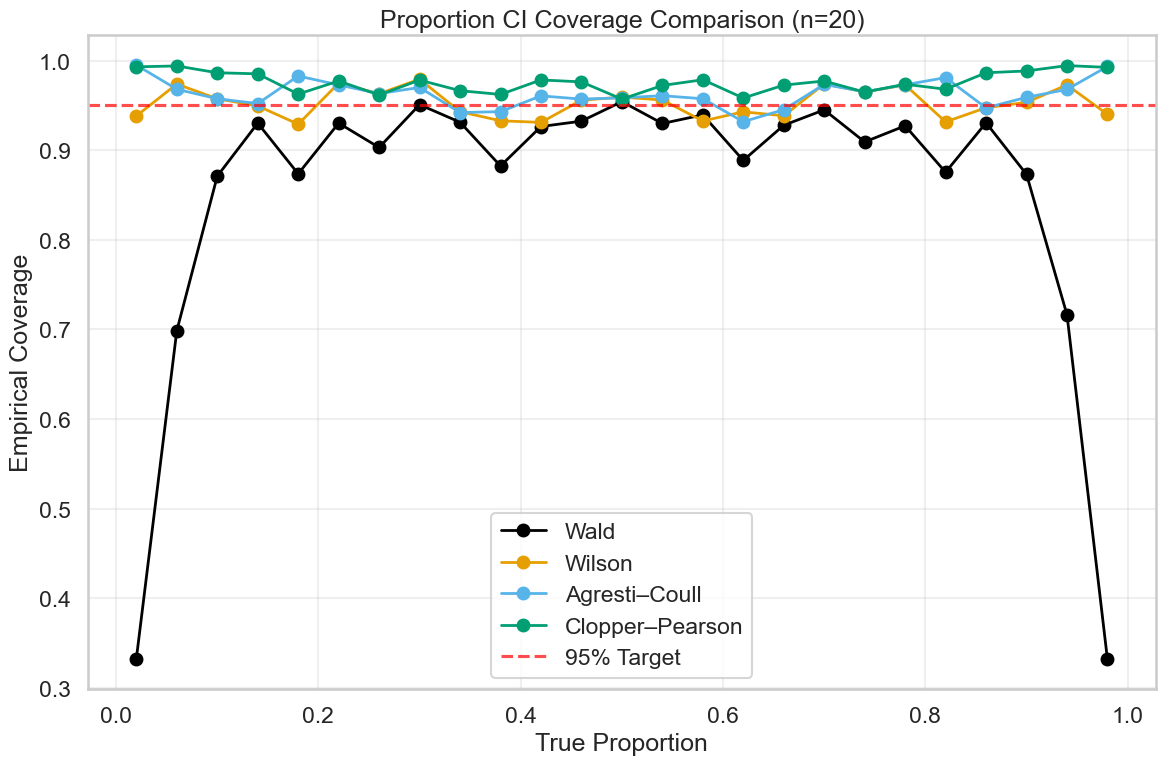

Coverage plot saved


In [10]:
# Plot coverage curves
plt.figure(figsize=(12, 8))

methods = coverage_results['method'].unique()
for method in methods:
    data = coverage_results[coverage_results['method'] == method]
    plt.plot(data['p'], data['coverage'], marker='o', linewidth=2, label=method)

plt.axhline(0.95, color='red', linestyle='--', alpha=0.7, label='95% Target')
plt.xlabel('True Proportion')
plt.ylabel('Empirical Coverage')
plt.title('Proportion CI Coverage Comparison (n=20)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/proportion_ci_coverage.png', dpi=150, bbox_inches='tight')
plt.show()

print("Coverage plot saved")

## 5. Delta Method for Functions of Parameters

Demonstrate the delta method for confidence intervals of parameter functions.

In [11]:
def delta_method_ci(g, g_prime, theta_hat, se_theta, alpha=0.05):
    """
    Delta method confidence interval for g(theta).

    Parameters:
    -----------
    g : callable
        Function g(theta)
    g_prime : callable
        Derivative g'(theta)
    theta_hat : float
        Point estimate of theta
    se_theta : float
        Standard error of theta_hat
    alpha : float
        Significance level

    Returns:
    --------
    tuple: (lower, upper) confidence limits
    """
    z = stats.norm.ppf(1 - alpha/2)
    g_hat = g(theta_hat)
    g_prime_hat = g_prime(theta_hat)
    se_g = abs(g_prime_hat) * se_theta

    return g_hat - z*se_g, g_hat + z*se_g

print("Function defined: delta_method_ci")

Function defined: delta_method_ci


In [12]:
# Example: Coefficient of variation CV = sigma/mu
def cv_func(sigma, mu):
    return sigma / mu

def cv_prime_sigma(sigma, mu):
    return 1 / mu

def cv_prime_mu(sigma, mu):
    return -sigma / (mu**2)

# Simulate data
true_mu = 10.0
true_sigma = 3.0
n = 100
sample = rng.normal(true_mu, true_sigma, n)

# Estimates
mu_hat = np.mean(sample)
sigma_hat = np.std(sample, ddof=1)
cv_hat = sigma_hat / mu_hat

# Standard errors (asymptotic)
se_mu = true_sigma / np.sqrt(n)  # Using true sigma for simplicity
se_sigma = true_sigma / np.sqrt(2*(n-1))  # Approximate for variance estimator

# Delta method for CV
cv_lo, cv_hi = delta_method_ci(
    lambda theta: cv_func(theta, mu_hat),  # Fix mu, vary sigma
    lambda theta: cv_prime_sigma(theta, mu_hat),
    sigma_hat,
    se_sigma
)

print(f"Sample CV: {cv_hat:.4f}")
print(f"Delta method CI: [{cv_lo:.4f}, {cv_hi:.4f}]")
print(f"True CV: {true_sigma/true_mu:.4f}")
print(f"CI contains true value: {cv_lo <= true_sigma/true_mu <= cv_hi}")

Sample CV: 0.3468
Delta method CI: [0.3064, 0.3872]
True CV: 0.3000
CI contains true value: False


## 6. Summary and Key Takeaways

This notebook demonstrated:
1. Construction of confidence intervals for means, variances, and proportions
2. Comparison of different proportion CI methods using A/B testing data
3. Empirical coverage simulation to evaluate CI performance
4. Application of the delta method for functions of parameters

Key insights:
- t-intervals provide better small-sample performance than Z-intervals
- Wilson and Agresti-Coull intervals improve on Wald for proportions
- Delta method enables inference for complex parameter functions
- Empirical simulation is crucial for understanding CI behavior
- A/B testing data provides realistic examples for CI comparison